# Trabajo Práctico 2 - Organización de Datos
## Competencia de Machine Learning
### Facultad de Ingeniería de la Universidad de Buenos Aires
### 95-58: Organización de Datos - 2do Cuat. 2018

#### Integrantes: Gonzalo Diz,  Ariel Windey, Gabriel Robles y Matías El Dócil




#### Objetivo
Determinar, para cada usuario presentado, cuál es la probabilidad de que ese
usuario realice una conversión en Trocafone en un periodo determinado.

#### Fuentes
El archivo "events_up_to_01062018.csv" contiene en el mismo formato utilizado en el TP1
información de eventos realizado en la plataforma para un conjunto de usuarios hasta el
31/05/2018.

Por otro lado el archivo "labels_training_set.csv" indica para un subconjunto de los
usuarios incluidos en el set de eventos "events_up_to_01062018.csv" si los mismos
realizaron una conversión (columna label = 1) o no (columna label = 0) desde el 01/06/2018
hasta el 15/06/2018.

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as skl

%matplotlib inline

pd.set_option('display.max_columns', 51)

In [190]:
# Carga del set de datos de eventos
eventos = pd.read_csv('../dataset/events_up_to_01062018.csv', low_memory=False)
# Carga del set de datos de labels
labels = pd.read_csv('../dataset/labels_training_set.csv', low_memory=False)


In [191]:
eventos.shape

(2341681, 23)

In [192]:
eventos.sample(5)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
1525484,2018-05-18 18:42:20,viewed product,5a97755f,NaN,5907.0,iPhone 5s,Bom - Sem Touch ID,16GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1066709,2018-02-09 05:57:07,search engine hit,6e49e51d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
570630,2018-05-04 17:33:18,viewed product,d9e83eae,NaN,1310.0,iPhone 6,Muito Bom,16GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1951663,2018-05-26 20:33:24,generic listing,b392e955,NaN,NaN,NaN,NaN,NaN,NaN,"2820,6706,2750,6720,6649,7252,7224,6663,12604,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1183447,2018-05-17 23:43:50,viewed product,be1cf105,NaN,7167.0,Samsung Galaxy S6 Edge Plus,Excelente,32GB,Preto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
# Formateo los eventos
eventos['timestamp'] = pd.to_datetime(eventos['timestamp'])

## Feature: Marca Favorita

Para cada persona, se indicara su marca favorita, que significa la marca que mas checkouts, conversiones y viewed product.

Filtro de eventos las columnas person y model

In [194]:
marcas = eventos.loc[:, ['person', 'model']]

Agrego columnas que categorizan el modelo por marca

In [195]:
marcas['apple'] = (marcas['model'].str.contains('iphone', case=False)) | (marcas['model'].str.contains('ipad', case=False))
marcas['motorola'] = marcas['model'].str.contains('motorola', case=False)
marcas['samsung'] = marcas['model'].str.contains('samsung', case=False)
marcas['lg'] = marcas['model'].str.contains('lg', case=False)
marcas['blackberry'] = marcas['model'].str.contains('blackberry', case=False)
marcas['sony'] = marcas['model'].str.contains('sony', case=False)
marcas['asus'] = marcas['model'].str.contains('asus', case=False)
marcas['lenovo'] = marcas['model'].str.contains('lenovo', case=False)
marcas['quantum'] = marcas['model'].str.contains('quantum', case=False)

Los usuarios que nunca realizaron algun evento del tipo "checkout", "conversion" o "viewed product" no tendrán marcas asociadas, de ahí los valores NaN. Los descarto ya que no son representativos.

In [196]:
marcas = marcas[pd.notnull(marcas['model'])]
marcas.sample(15)

,person,model,apple,motorola,samsung,lg,blackberry,sony,asus,lenovo,quantum
809189,77cf895a,Samsung Galaxy S8 Plus,False,False,True,False,False,False,False,False,False
767623,10871bbb,Samsung Galaxy Note Edge,False,False,True,False,False,False,False,False,False
1475157,bc62bc70,Samsung Galaxy Y Duos,False,False,True,False,False,False,False,False,False
1483699,d0c5aa85,Motorola Moto G4 Plus,False,True,False,False,False,False,False,False,False
591181,c41c0142,Motorola Moto Z,False,True,False,False,False,False,False,False,False
1374647,0aa463a0,LG G4 H815P,False,False,False,True,False,False,False,False,False
624365,8e6dc1fe,iPhone 5s,True,False,False,False,False,False,False,False,False
844943,422bc4d7,Samsung Galaxy A7 2016,False,False,True,False,False,False,False,False,False
813394,49f9915f,Motorola Moto G4 Plus,False,True,False,False,False,False,False,False,False
51858,cf93907d,LG L Prime D337,False,False,False,True,False,False,False,False,False


In [197]:
marcas.loc[(marcas['apple'] == False) & (marcas['motorola'] == False) & (marcas['samsung'] == False) & (marcas['lg'] == False) & (marcas['blackberry'] == False) & (marcas['sony'] == False) & (marcas['asus'] == False) & (marcas['lenovo'] == False) & (marcas['quantum'] == False), :]['model'].value_counts()

Xiaomi Redmi 2      1
Outros TV LED 15    1
Name: model, dtype: int64

Ya no se necesita la columna "modelo", pues tenemos cada marca categorizada por columnas.

In [198]:
marcas = marcas.drop('model', axis=1)
marcas.head()

,person,apple,motorola,samsung,lg,blackberry,sony,asus,lenovo,quantum
0,4886f805,False,False,True,False,False,False,False,False,False
1,ad93850f,True,False,False,False,False,False,False,False,False
2,0297fc1e,True,False,False,False,False,False,False,False,False
3,2d681dd8,True,False,False,False,False,False,False,False,False
4,cccea85e,False,False,False,True,False,False,False,False,False


Agrupamos por persona sumando cada tipo de marca asociada.

In [199]:
marcas = marcas.groupby('person').agg({'apple':'sum', 'motorola':'sum', 'samsung': 'sum', 'lg':'sum', 'blackberry':'sum', 'sony':'sum', 'asus':'sum', 'lenovo':'sum', 'quantum':'sum'})

Las sumas vuelven en tipo object, las pasamos a float.

In [200]:
marcas = marcas.astype('float64')

Nos quedamos con la marca favorita de cada persona con idmax(axis=1)

In [201]:
marcas['marca_favorita'] = marcas.idxmax(axis=1)
marcas.sample(10)
marcas = marcas.reset_index()

In [202]:
marcas_favoritas = marcas.loc[:, ['person', 'marca_favorita']]
marcas_favoritas.head()

,person,marca_favorita
0,0008ed71,apple
1,00091926,apple
2,00091a7a,apple
3,000ba417,samsung
4,000c79fe,apple


In [203]:
marcas_favoritas['marca_favorita'].value_counts()

apple       16613
samsung     16410
motorola     4406
lg            434
sony          192
lenovo        158
asus           32
quantum        11
Name: marca_favorita, dtype: int64

In [204]:
marcas_favoritas.shape

(38256, 2)

Liberamos recursos

In [205]:
marcas = 0

## Feature: Actividad de Usuario

Para cada persona, se creará una categoría que indicará su nivel de actividad en la plataforma. Para elaborar la misma, se medirá la cantidad de eventos totales generados por un usuario, y se tendrá el tiempo que tiene el usuario en la plataforma (diferencia de tiempo en dias desde el primer evento generado al último). Finalmente se creará una métrica que será CANTIDAD_EVENTOS_TOTALES / DIAS_EN_LA_PLATAFORMA. En base a este valor se categorizarán los usuarios.

In [305]:
eventos.sample(5)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
2119958,2018-05-11 11:28:50,generic listing,d6d26d57,NaN,NaN,NaN,NaN,NaN,NaN,"6594,6651,2820,6706,6720,478,7238,2773,7309,78...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2144034,2018-05-29 16:09:43,visited site,6f4de109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paid,Returning,Itapora,Mato Grosso do Sul,Brazil,Computer,1366x768,Windows 7,Chrome 66.0
413767,2018-05-27 20:15:06,viewed product,fd640a51,NaN,3347.0,Samsung Galaxy S6 Flat,Bom,32GB,Branco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2038103,2018-05-29 11:54:17,brand listing,8be4d720,NaN,NaN,NaN,NaN,NaN,NaN,"6874,6930,8994",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
321007,2018-03-26 19:22:29,ad campaign hit,72a3ac87,/comprar/iphone/6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,criteo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [306]:
actividad_timestamp = eventos[['person', 'timestamp']] 

#### Obtengo la cantidad de días que cada usuario tiene en la plataforma

In [310]:
dias_en_plataforma = actividad_timestamp.groupby('person').agg({'timestamp': ['min','max']}).reset_index()
dias_en_plataforma.columns = ['person', 'min', 'max']
dias_en_plataforma['dias_en_plataforma'] = dias_en_plataforma['max'] - dias_en_plataforma['min']
dias_en_plataforma['dias_en_plataforma_float'] = (dias_en_plataforma['dias_en_plataforma'].dt.total_seconds() / (60*60*24))
dias_en_plataforma = dias_en_plataforma.drop(['min','max','dias_en_plataforma'],axis=1)
dias_en_plataforma = dias_en_plataforma.rename(columns={'dias_en_plataforma_float':'dias_en_plataforma'})
dias_en_plataforma.head()

,person,dias_en_plataforma
0,0008ed71,0.167245
1,00091926,27.905255
2,00091a7a,0.004016
3,000ba417,9.081678
4,000c79fe,0.007176


#### Obtengo la cantidad de eventos en días distintos que tiene cada persona

In [334]:
eventos['fecha'] = eventos['timestamp'].dt.date

Obtengo un dataframe con persona y día en que realizó un evento, con duplicados.

In [343]:
dias_con_eventos = eventos.loc[:,['person', 'fecha']]
dias_con_eventos.shape

(2341681, 2)

In [344]:
dias_con_eventos.head()

,person,fecha
0,4886f805,2018-05-18
1,ad93850f,2018-05-18
2,0297fc1e,2018-05-18
3,2d681dd8,2018-05-18
4,cccea85e,2018-05-18


Quito los duplicados

In [346]:
dias_con_eventos = dias_con_eventos.drop_duplicates()
dias_con_eventos.shape

(138421, 2)

In [349]:
dias_con_eventos_agg = dias_con_eventos.groupby('person').count().reset_index()
dias_con_eventos_agg = dias_con_eventos_agg.rename(columns={'fecha':'dias_distintos_con_eventos'})

In [350]:
dias_con_eventos_agg.head()

,person,dias_distintos_con_eventos
0,0008ed71,1
1,00091926,22
2,00091a7a,1
3,000ba417,3
4,000c79fe,1


#### Obtengo la cantidad de eventos totales por persona

In [358]:
actividad = eventos.loc[:, ['person', 'event']]
actividad.head()

,person,event
0,4886f805,viewed product
1,ad93850f,viewed product
2,0297fc1e,viewed product
3,2d681dd8,viewed product
4,cccea85e,viewed product


In [363]:
eventos_por_persona = actividad.groupby(['person']).count().reset_index()
eventos_por_persona = eventos_por_persona.rename(columns={'event':'eventos_totales_generados'})
eventos_por_persona.head()

,person,eventos_totales_generados
0,0008ed71,6
1,00091926,448
2,00091a7a,10
3,000ba417,206
4,000c79fe,17


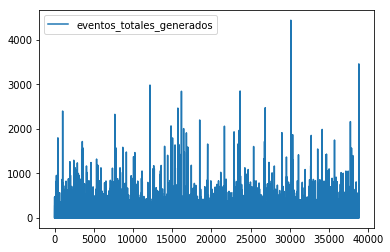

In [364]:
eventos_por_persona.plot()

In [354]:
actividad.mean()

event    60.307528
dtype: float64

In [268]:
actividad_muy_alto = 500
actividad_alto = 100
actividad_medio = 50
actividad_bajo = 20
actividad_muy_bajo = 20

In [269]:
actividad_auxiliar = pd.cut(actividad.stack(), [0, actividad_bajo, actividad_medio, actividad_alto, actividad_muy_alto, np.inf], labels=['muy bajo', 'bajo', 'medio', 'alto', 'muy alto'])
actividad_categoria = actividad.join(actividad_auxiliar.unstack().add_suffix('_categoria')).reset_index()
actividad_categoria = actividad_categoria.drop('event', axis=1)
actividad_categoria = actividad_categoria.rename(columns={'event_categoria':'nivel_actividad'})
actividad_categoria.head()

,person,nivel_actividad
0,0008ed71,muy bajo
1,00091926,alto
2,00091a7a,muy bajo
3,000ba417,alto
4,000c79fe,muy bajo


In [ ]:
actividad_categoria

In [206]:
# Promedio de eventos por persona

eventos_por_persona = eventos[['person', 'event']]
eventos_por_persona = eventos_por_persona.groupby(['person']).count().reset_index()
promedio_eventos_por_persona = eventos_por_persona['event'].sum() / eventos_por_persona.count()
promedio_eventos_por_persona

person    60.307528
event     60.307528
dtype: float64

In [268]:
personas = eventos['person'].to_frame().drop_duplicates()
personas.shape

(38829, 1)

## Feature 1: Cantidad de eventos por usuario

In [275]:
# Veo cantidad de eventos por persona

eventos['cantidad'] = 1
grouped = eventos.groupby(['person','event']).agg({'cantidad':'sum'})
grouped = grouped.unstack().reset_index()
grouped = grouped.fillna(value=0)

In [276]:
grouped.sample(5)


person        cantidad                                    \
event           ad campaign hit brand listing checkout conversion   
36143  ee58d70c             1.0           0.0      1.0        0.0   
33094  da8fcfea             2.0           3.0      0.0        0.0   
29225  c10a2db1             5.0           0.0      1.0        0.0   
20454  87d3961c             1.0           3.0      1.0        0.0   
11525  4c2000d4             2.0           0.0      2.0        0.0   

                                                                           \
event generic listing lead search engine hit searched products staticpage   
36143             1.0  0.0               1.0               3.0        0.0   
33094             0.0  0.0               0.0               0.0        0.0   
29225             1.0  0.0               4.0               0.0        0.0   
20454             1.0  0.0               0.0               1.0        0.0   
11525             0.0  0.0               0.0               0.0        0.0   

                                   
event viewed product visited site  
36143            5.0          1.0  
33094            0.0          1.0  
29225           16.0          3.0  
20454           11.0          1.0  
11525           13.0          1.0

In [277]:
grouped.columns = ['person','ad campaign hit', 'brand listing', 'checkout', 'conversion', 'generic listing', 'lead', 'search engine hit', 'searched products', 'staticpage', 'viewed product', 'visited site']
grouped.sample(5)

,person,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site
29961,c622d79d,3.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0
32628,d76ff6ff,7.0,1.0,4.0,0.0,0.0,0.0,3.0,6.0,0.0,139.0,7.0
26126,acbc9760,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
23092,98ffe412,7.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,13.0,7.0
34363,e29a9761,3.0,1.0,1.0,0.0,2.0,0.0,3.0,0.0,0.0,9.0,2.0


In [278]:
grouped = grouped.set_index('person')
grouped.sample(5)

,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site
person,,,,,,,,,,,
0eca7ed3,31.0,12.0,2.0,0.0,30.0,0.0,44.0,90.0,0.0,127.0,14.0
d72d80b3,0.0,0.0,1.0,0.0,2.0,0.0,2.0,4.0,0.0,7.0,2.0
a896b933,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
843e9159,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1a71716a,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0


In [282]:
non_visit = grouped.loc[grouped['visited site'] == 0]
non_visit.shape

(587, 11)

Tenemos la cantidad de eventos por cada persona

In [267]:
grouped.shape

(38829, 11)

Como todos las personas realizaron al menos un evento, no hace falta hacer el join con persons.

In [299]:
grouped.to_csv('events_qty_per_person.csv')

## Feature 2: Dispositivos

Para cada persona, se tendrá la cantidad de "device type" utilizados. Este es un feature para el evento "visited site"

In [271]:
eventos.sample(5)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version,cantidad
5404,2018-05-29 19:46:20,viewed product,c7fba740,NaN,9286.0,Samsung Galaxy J7 Prime,Bom,32GB,Dourado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2068040,2018-05-22 23:54:33,generic listing,1db0efa0,NaN,NaN,NaN,NaN,NaN,NaN,"6594,6636,1061,6707,2750,12619,11346,2766,1260...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
826480,2018-05-25 23:53:59,viewed product,85e44e49,NaN,2939.0,Sony Xperia Z2,Bom,16GB,Preto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2091479,2018-05-02 15:27:19,brand listing,fcead3d1,NaN,NaN,NaN,NaN,NaN,NaN,"12758,12744,12772,8541,8513,8485,8471,8527,641...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
336391,2018-04-30 13:25:58,viewed product,a8ece5ba,NaN,12745.0,Samsung Galaxy S8,Muito Bom,64GB,Ametista,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [286]:
dispositivos = eventos.groupby(['person', 'device_type']).agg({'cantidad':'sum'})
dispositivos = dispositivos.unstack().reset_index()
dispositivos = dispositivos.fillna(value=0)

In [287]:
dispositivos.columns = ['person','Computer', 'Smartphone', 'Tablet', 'Unknown']
dispositivos = dispositivos.set_index('person')
dispositivos.sample(5)

,Computer,Smartphone,Tablet,Unknown
person,,,,
42d2dd49,1.0,0.0,0.0,0.0
94d38c82,0.0,5.0,0.0,0.0
4f8a4a9f,1.0,0.0,0.0,0.0
6a989c01,3.0,0.0,0.0,0.0
03bcd854,1.0,0.0,0.0,0.0


In [288]:
dispositivos.shape

(38242, 4)

Veo que quedaron personas afuera, significa que hay personas que no tienen ningun device_type asociado, esto es, porque no tienen ningun evento registrado del tipo "visited site". Haremos un merge con persons.

In [297]:
dispositivos = pd.merge(dispositivos, personas, on='person', how='right')
dispositivos = dispositivos.fillna(value=0)

In [300]:
dispositivos.to_csv('device_types_qty_per_person.csv')